# Packages and Data

In [1]:
import numpy as np
from numpy import linalg
from scipy.sparse import linalg as sparla
import seaborn as sns
from sklearn import svm
from sklearn import metrics
from sklearn import inspection
import cvxpy as cp

<AxesSubplot:>

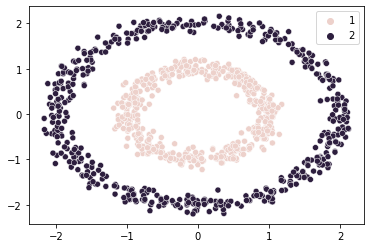

In [2]:
n = 1000
label = np.random.choice([1, 2], n)
d = np.random.normal(label, 0.1)
r = np.random.uniform(0, 2*np.pi, n)
x1 = d*np.cos(r)
x2 = d*np.sin(r)
sns.scatterplot(x=x1, y=x2, hue=label)

In [3]:
X = np.column_stack([x1, x2])
Y = np.where(label==label[0], 1, -1)
X.shape, Y.shape

((1000, 2), (1000,))

# Linear and RBF Kernel

[[213 283]
 [156 348]]


<AxesSubplot:>

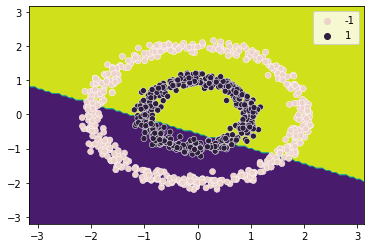

In [4]:
model = svm.SVC(kernel='linear')
model.fit(X, Y)
Z = model.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
)

sns.scatterplot(x=x1, y=x2, hue=Y)

[[496   0]
 [  0 504]]


<AxesSubplot:>

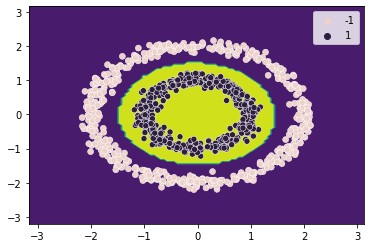

In [5]:
model = svm.SVC(kernel='rbf')
model.fit(X, Y)
Z = model.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        response_method="predict",
)

sns.scatterplot(x=x1, y=x2, hue=Y)

# Primal Optimization

In [6]:
class SVC_Primal:
    def __init__(self, C=1):
        self.C = C
    def fit(self, X, Y):
        n, p = X.shape
        E = cp.Variable(n)
        W = cp.Variable(p)
        Objective = cp.Minimize(0.5*cp.sum_squares(W) + self.C*cp.sum(E))
        Constraints = [
            E >= 1 - cp.multiply(Y, cp.matmul(X, W)),
            E >= 0,
        ]
        Problem = cp.Problem(Objective, Constraints)
        Problem.solve(solver='MOSEK')
        self.W_ = W.value
    def predict(self, X):
        Y = np.matmul(X, self.W_)
        return np.where( Y >= 0, 1, -1 )

[[264 232]
 [246 258]]


<AxesSubplot:>

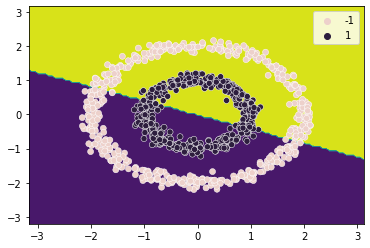

In [7]:
model_primal = SVC_Primal()
model_primal.fit(X, Y)
Z = model_primal.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model_primal,
        X,
        response_method="predict",
)
sns.scatterplot(x=x1, y=x2, hue=Y)

# Dual Optimization

Please follow the above examples to implement the SVM dual optimization

In [15]:
class SVC_Dual:
    def __init__(self, kernel, C=1):
        self.kernel = kernel
        self.C = C
    def fit(self, X, Y):
        self.X_, self.Y_ = X, Y
        
        K = self.kernel(X, self.X_)
        K = np.multiply(K, Y[:, None])
        K = np.multiply(K, Y[None, :])
        
        K = cp.atoms.affine.wraps.psd_wrap(K)
        
        n = len(Y)
        L = cp.Variable(n)
        
        Objective = cp.Minimize(0.5*cp.quad_form(L, K) - cp.sum(L))
        Constraints = [
            L <= self.C,
            L >= 0,
        ]
        Problem = cp.Problem(Objective, Constraints)
        Problem.solve(solver='MOSEK')
        self.L_ = L.value
    def predict(self, X):
        K = self.kernel(X, self.X_)
        Y = np.matmul(K, np.multiply(self.L_, self.Y_))
        return np.where( Y >= 0, 1, -1 )

[[264 232]
 [246 258]]


<AxesSubplot:>

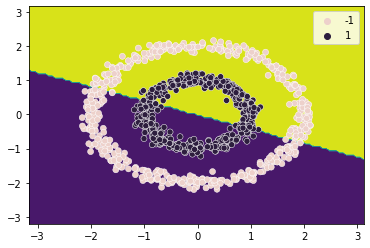

In [17]:
model_primal = SVC_Dual(kernel=metrics.pairwise.linear_kernel)
model_primal.fit(X, Y)
Z = model_primal.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model_primal,
        X,
        response_method="predict",
)
sns.scatterplot(x=x1, y=x2, hue=Y)

[[496   0]
 [  0 504]]


<AxesSubplot:>

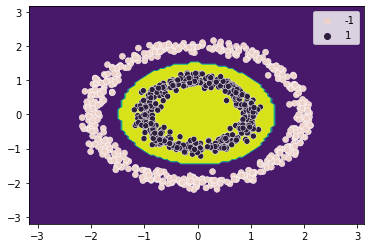

In [16]:
model_primal = SVC_Dual(kernel=metrics.pairwise.rbf_kernel)
model_primal.fit(X, Y)
Z = model_primal.predict(X)

print( metrics.confusion_matrix(Y, Z) )

inspection.DecisionBoundaryDisplay.from_estimator(
        model_primal,
        X,
        response_method="predict",
)
sns.scatterplot(x=x1, y=x2, hue=Y)